# CNN — Clasificación de Imágenes (CIFAR-10)

In [1]:
import sys, os
sys.path.append(os.path.abspath("..")) 

In [2]:
# Reproducibilidad 
import os, random, numpy as np, tensorflow as tf
seed=42; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)


1) Importaciones y datos

In [3]:
import tensorflow as tf
from src.data import get_cifar10_tf
from src.models import build_cnn
from src.train import compile_and_train
from src.utils import plot_history
import numpy as np

(x_train, y_train), (x_test, y_test) = get_cifar10_tf()
# Split validación
val_frac = 0.1
n_val = int(len(x_train)*val_frac)
x_val, y_val = x_train[:n_val], y_train[:n_val]
x_tr , y_tr  = x_train[n_val:], y_train[n_val:]

x_tr.shape, x_val.shape, x_test.shape


((45000, 32, 32, 3), (5000, 32, 32, 3), (10000, 32, 32, 3))

2) Definición del modelo y entrenamiento

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
704/704 - 20s - 28ms/step - accuracy: 0.3061 - loss: 1.8173 - val_accuracy: 0.4334 - val_loss: 1.5640 - learning_rate: 1.0000e-03
Epoch 2/15
704/704 - 19s - 26ms/step - accuracy: 0.4321 - loss: 1.5351 - val_accuracy: 0.5064 - val_loss: 1.3737 - learning_rate: 1.0000e-03
Epoch 3/15
704/704 - 18s - 26ms/step - accuracy: 0.4894 - loss: 1.3893 - val_accuracy: 0.5372 - val_loss: 1.2527 - learning_rate: 1.0000e-03
Epoch 4/15
704/704 - 20s - 28ms/step - accuracy: 0.5276 - loss: 1.2893 - val_accuracy: 0.5836 - val_loss: 1.1578 - learning_rate: 1.0000e-03
Epoch 5/15
704/704 - 20s - 29ms/step - accuracy: 0.5536 - loss: 1.2220 - val_accuracy: 0.6020 - val_loss: 1.1117 - learning_rate: 1.0000e-03
Epoch 6/15
704/704 - 23s - 33ms/step - accuracy: 0.5796 - loss: 1.1605 - val_accuracy: 0.6142 - val_loss: 1.0748 - learning_rate: 1.0000e-03
Epoch 7/15
704/704 - 38s - 54ms/step - accuracy: 0.5966 - loss: 1.1138 - val_accuracy: 0.6384 - val_loss: 1.0070 - learning_rate: 1.0000e-03
Epoch 8/15
70

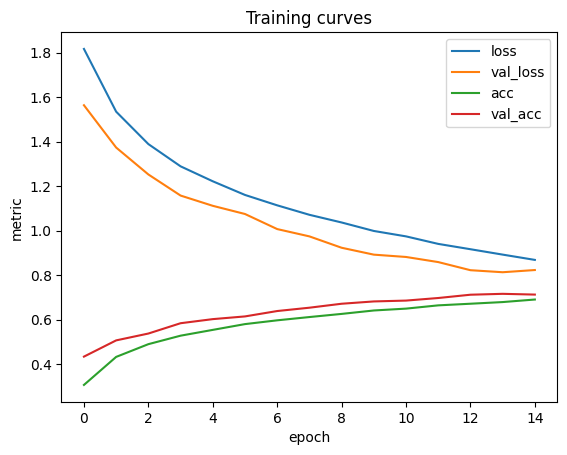

Test metrics: {'loss': 0.8304487466812134, 'compile_metrics': 0.7053999900817871}


In [4]:
model = build_cnn()
hist = compile_and_train(model, x_tr, y_tr, x_val, y_val, epochs=15, batch_size=64)
plot_history(hist)
test_metrics = model.evaluate(x_test, y_test, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))


3) Métricas

In [5]:
from src.metrics import classification_report_tf, save_history_curves, count_params
from src.utils import append_summary_row, now_ts
import os, time

os.makedirs("../results/cnn", exist_ok=True)
start = time.time()
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
train_time = time.time()-start

# Curvas
save_history_curves(hist, "../results/cnn/learning_curves.png")

# Matriz de confusión + métricas
rep = classification_report_tf(model, x_test, y_test, label_names=list(range(10)), save_cm_path="../results/cnn/confusion_matrix.png")

append_summary_row("../results/summary.csv", {
    "timestamp": now_ts(),
    "module": "cnn",
    "model": "SimpleCNN",
    "dataset": "CIFAR-10",
    "accuracy": rep["accuracy"],
    "f1": rep["f1"],
    "loss": float(test_loss),
    "epochs": len(hist.history.get("loss", [])),
    "params": int(count_params(model)),
    "train_time_s": round(train_time, 2),
    "notes": "baseline"
})
print("Resumen agregado a results/summary.csv")


Resumen agregado a results/summary.csv


4) Data Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                         horizontal_flip=True, zoom_range=0.1)
train_flow = aug.flow(x_tr, y_tr, batch_size=64, shuffle=True)
# Reentrenar breve para ver impacto 
hist_aug = model.fit(train_flow, validation_data=(x_val, y_val), epochs=3)

Epoch 1/3
  1/704 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.6719 - loss: 0.9211

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.6315 - loss: 1.0342 - val_accuracy: 0.6868 - val_loss: 0.8808
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.6492 - loss: 0.9861 - val_accuracy: 0.6892 - val_loss: 0.8716
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.6535 - loss: 0.9716 - val_accuracy: 0.6926 - val_loss: 0.8723


5) Ejemplos correctamente e incorrectamente clasificados

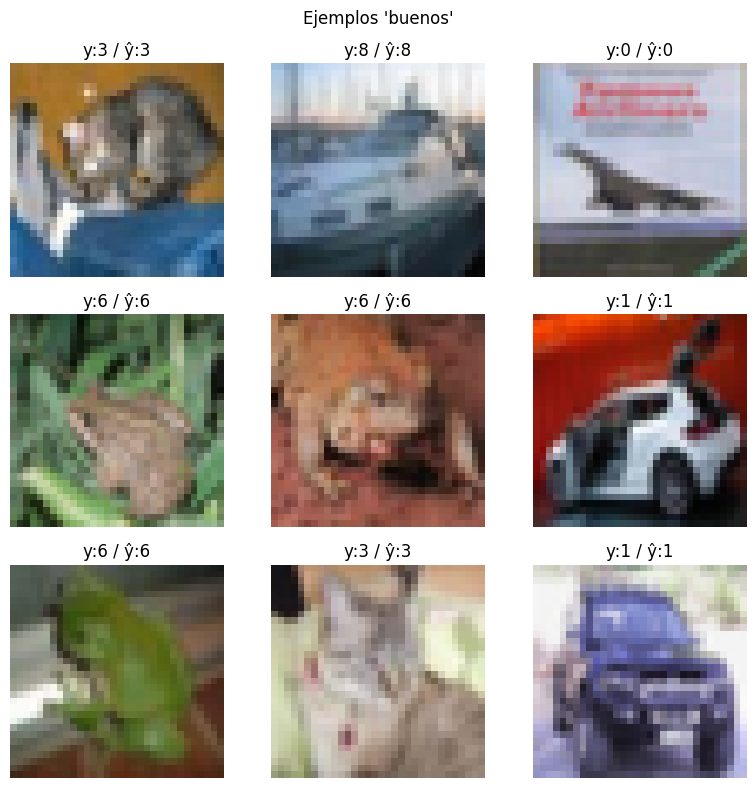

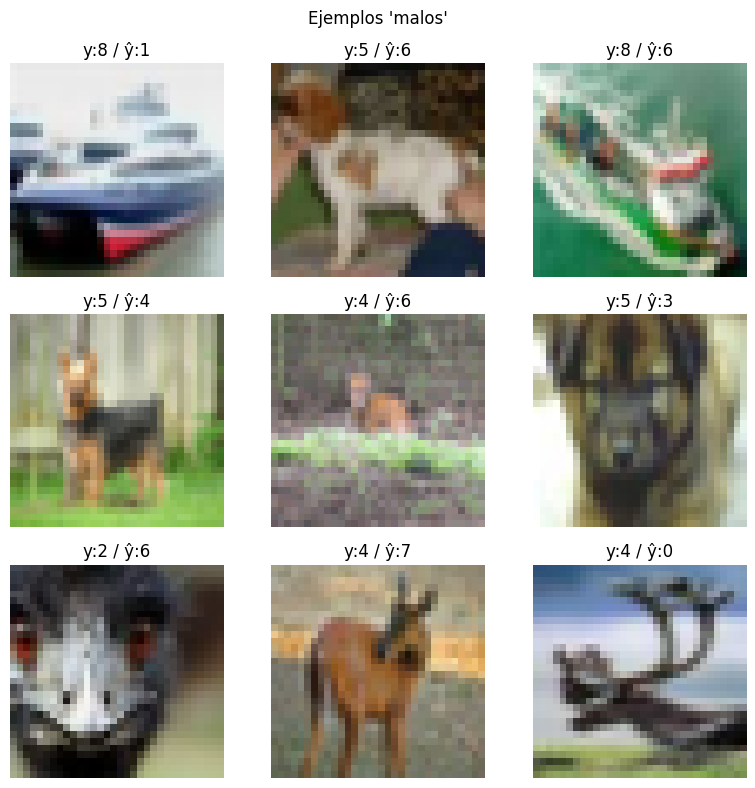

In [7]:
import numpy as np, matplotlib.pyplot as plt
# Predicciones sobre test
y_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1).reshape(-1)
y_true = y_test.reshape(-1)

hits = np.where(y_pred==y_true)[0]
errs = np.where(y_pred!=y_true)[0]

def show_samples(idxs, title):
    plt.figure(figsize=(8,8))
    for i, idx in enumerate(idxs[:9]):
        plt.subplot(3,3,i+1); plt.imshow(x_test[idx]); plt.axis('off')
        plt.title(f"y:{y_true[idx]} / ŷ:{y_pred[idx]}")
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_samples(list(hits)[:9], "Ejemplos 'buenos'")
show_samples(list(errs)[:9], "Ejemplos 'malos'")